In [1]:
import os
import json
from globals import BASE_DIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [583]:
# Define the datasets you want to process
available_datasets = ["brightkite", "foursquaretky", "gowalla", "snowcard", "yelp"]

data = []
for dataset in available_datasets:
    recs = os.listdir(f"{BASE_DIR}{dataset}_dataset/recommendations")
    if '.DS_Store' in recs:
        recs.remove('.DS_Store')
    

    for dir in recs:
        print(dir)
        json_file = f"{BASE_DIR}{dataset}_dataset/recommendations/{dir}/general_evaluation.json"
        
        # Load the JSON data
        with open(json_file, 'r') as f:
            eval_data = json.load(f)
        
        # Extract the test_result data and flatten it
        test_results = eval_data.get("test_result", {})
        
        # Add the directory name to the test_results dictionary
        test_results["directory"] = dir

        test_results["dataset"] = test_results["directory"].split("-")[0]
        test_results["model"] = test_results["directory"].split("-")
        if test_results["directory"].split("-")[1] == "debias":
            test_results["model_type"] = "debias"
        else:
            test_results["model_type"] = "general"

        if test_results["model_type"] == "debias":
            test_results["model"] = test_results["model"][2]
        else:
            test_results["model"] = test_results["model"][1]

        if test_results["model"] == "MF":
            test_results["model_type"] = "general (via RecBole debias)"

        test_results["dataset"] = test_results["dataset"].split("_")[0]


        # Append the data to the list
        data.append(test_results)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

df.drop(columns=["directory"], inplace=True)

# Display the DataFrame





brightkite_sample-BPR-Sep-11-2024_21-42-02
brightkite_sample-debias-MACR-Aug-22-2024_15-22-09
brightkite_sample-debias-MF-Aug-22-2024_15-22-01
brightkite_sample-debias-PDA-Aug-22-2024_15-21-55
brightkite_sample-ItemKNN-Sep-11-2024_21-42-21
brightkite_sample-SimpleX-Sep-11-2024_21-42-10
foursquaretky_sample-BPR-Sep-11-2024_21-53-32
foursquaretky_sample-debias-MACR-Aug-22-2024_15-28-21
foursquaretky_sample-debias-MF-Aug-22-2024_15-27-57
foursquaretky_sample-debias-PDA-Aug-22-2024_15-27-06
foursquaretky_sample-ItemKNN-Sep-11-2024_21-55-11
foursquaretky_sample-SimpleX-Sep-11-2024_21-53-53
gowalla_sample-BPR-Sep-11-2024_21-42-23
gowalla_sample-debias-MACR-Aug-22-2024_15-25-42
gowalla_sample-debias-MF-Aug-22-2024_15-25-13
gowalla_sample-debias-PDA-Aug-22-2024_15-22-15
gowalla_sample-ItemKNN-Sep-11-2024_21-53-26
gowalla_sample-SimpleX-Sep-11-2024_21-46-59
snowcard_sample-BPR-Sep-11-2024_21-55-22
snowcard_sample-debias-MACR-Aug-22-2024_15-32-26
snowcard_sample-debias-MF-Aug-22-2024_15-29-58
sn

In [584]:
data

[{'recall@10': 0.1834,
  'mrr@10': 0.3322,
  'ndcg@10': 0.1789,
  'hit@10': 0.5883,
  'precision@10': 0.0972,
  'map@10': 0.1015,
  'giniindex@10': 0.82,
  'tailpercentage@10': 0.0,
  'directory': 'brightkite_sample-BPR-Sep-11-2024_21-42-02',
  'dataset': 'brightkite',
  'model': 'BPR',
  'model_type': 'general'},
 {'recall@10': 0.1891,
  'mrr@10': 0.3627,
  'ndcg@10': 0.1903,
  'hit@10': 0.6,
  'precision@10': 0.1005,
  'map@10': 0.1083,
  'giniindex@10': 0.8566,
  'tailpercentage@10': 0.0,
  'directory': 'brightkite_sample-debias-MACR-Aug-22-2024_15-22-09',
  'dataset': 'brightkite',
  'model': 'MACR',
  'model_type': 'debias'},
 {'recall@10': 0.1672,
  'mrr@10': 0.3182,
  'ndcg@10': 0.1645,
  'hit@10': 0.5783,
  'precision@10': 0.09,
  'map@10': 0.0897,
  'giniindex@10': 0.8528,
  'tailpercentage@10': 0.0,
  'directory': 'brightkite_sample-debias-MF-Aug-22-2024_15-22-01',
  'dataset': 'brightkite',
  'model': 'MF',
  'model_type': 'general (via RecBole debias)'},
 {'recall@10': 0.18

In [585]:


df = df[['dataset',
 'model',
 'model_type',
 'recall@10',
 'mrr@10',
 'ndcg@10',
 'hit@10',
 'precision@10',
 'map@10',
 'giniindex@10',
 'tailpercentage@10']]

In [586]:
df.sort_values(by=['dataset', 'ndcg@10'], ascending=[True, False])

,dataset,model,model_type,recall@10,mrr@10,ndcg@10,hit@10,precision@10,map@10,giniindex@10,tailpercentage@10
1,brightkite,MACR,debias,0.1891,0.3627,0.1903,0.6000,0.1005,0.1083,0.8566,0.0000
3,brightkite,PDA,debias,0.1802,0.3577,0.1833,0.5883,0.0955,0.1037,0.9169,0.0000
5,brightkite,SimpleX,general,0.1834,0.3570,0.1824,0.5817,0.0953,0.1029,0.7381,0.0065
0,brightkite,BPR,general,0.1834,0.3322,0.1789,0.5883,0.0972,0.1015,0.8200,0.0000
2,brightkite,MF,general (via RecBole debias),0.1672,0.3182,0.1645,0.5783,0.0900,0.0897,0.8528,0.0000
4,brightkite,ItemKNN,general,0.1518,0.2106,0.1299,0.4567,0.0765,0.0712,0.6142,0.0208
10,foursquaretky,ItemKNN,general,0.0957,0.2799,0.1154,0.5533,0.0840,0.0518,0.9042,0.0305
11,foursquaretky,SimpleX,general,0.0938,0.2662,0.1120,0.5473,0.0821,0.0500,0.9573,0.0017
6,foursquaretky,BPR,general,0.0909,0.2634,0.1083,0.5347,0.0785,0.0483,0.9596,0.0008
7,foursquaretky,MACR,debias,0.0889,0.2606,0.1067,0.5367,0.0779,0.0470,0.9751,0.0000


In [587]:
df.to_csv(f"{BASE_DIR}/evaluation_results.csv", index=False)

/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1985/2691333391.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="dataset", y="recall@10", hue="model", data=df, ci=None)


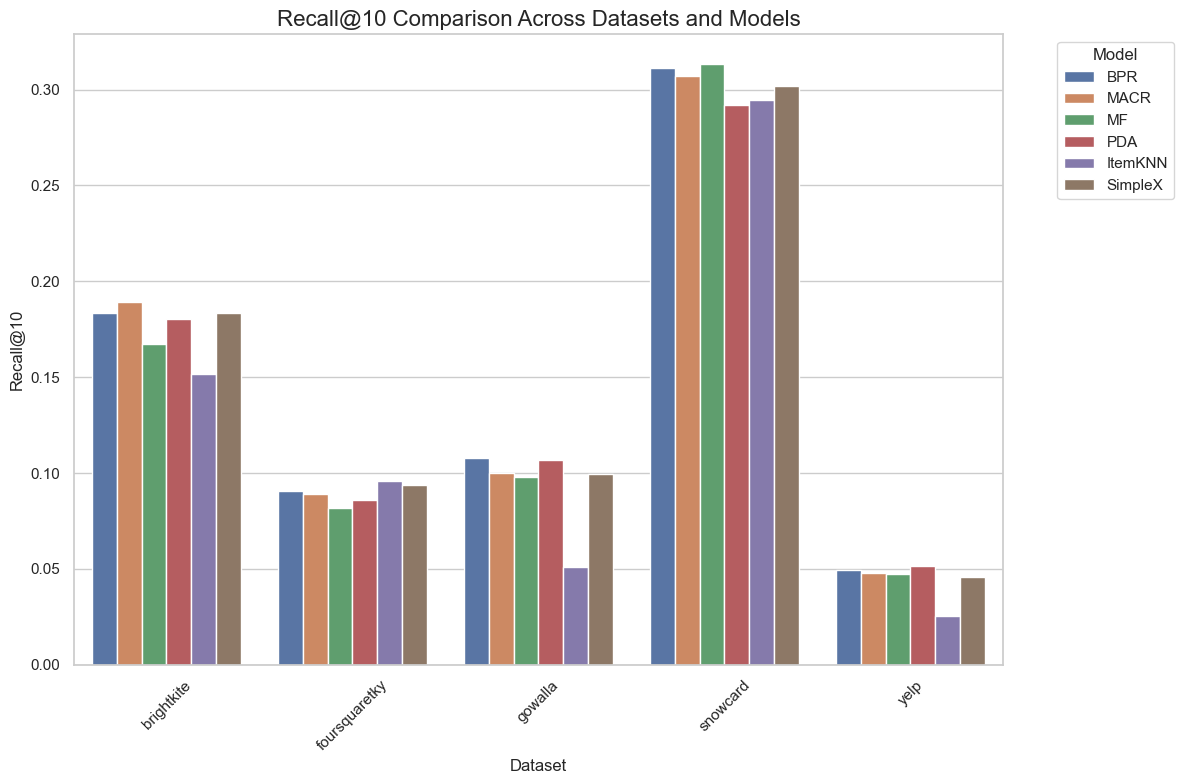

In [588]:

# Set plot style
sns.set(style="whitegrid")

# Plot NDCG@10 values for different models across datasets
plt.figure(figsize=(12, 8))
sns.barplot(x="dataset", y="recall@10", hue="model", data=df, ci=None)

# Add labels and title
plt.title('Recall@10 Comparison Across Datasets and Models', fontsize=16)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Recall@10', fontsize=12)
plt.xticks(rotation=45)

# Show plot
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [589]:
# # Ensure columns are numeric
# df['giniindex@10'] = pd.to_numeric(df['giniindex@10'])
# df['ndcg@10'] = pd.to_numeric(df['ndcg@10'])

# # Group by dataset and plot
# for dataset, data in df.groupby('dataset'):
#     plt.figure(figsize=(10, 6))
    
#     # Create a scatter plot
#     scatter_plot = sns.scatterplot( 
#         x='giniindex@10', 
#         y='ndcg@10',
#         data=data, 
#         hue='model',
#         palette='viridis', 
#         s=100,
#         edgecolor='black'
#     )
    
#     # Highlight the best model based on `ndcg@10`
#     best_ndcg = data['ndcg@10'].max()
#     best_model = data.loc[data['ndcg@10'] == best_ndcg, 'model'].values[0]
    
#     plt.title(f'NDCG@10 vs. Gini Index for Each Model - {dataset}')
#     plt.xlabel('Gini Index@10')
#     plt.ylabel('NDCG@10')
    
#     # # Annotate the best model
#     # for i, row in data.iterrows():
#     #     if row['model'] == best_model:
#     #         plt.text(
#     #             row['ndcg@10'], 
#     #             row['giniindex@10'] + 0.01,  # Offset to avoid overlap with the point
#     #             'Best', 
#     #             color='red', 
#     #             ha='center'
#     #         )
    
#     plt.tight_layout()  # Adjust layout to fit labels
#     plt.show()
#     DATASET_DIR = f"/Volumes/Forster Neu/Masterarbeit Data/{dataset}_dataset/"
#     plt.savefig(f'{DATASET_DIR}plots/NDCG@10 vs. Gini Index for Each Model - {dataset}.png', dpi=300)


## Helper Methods 

Popularity bias specific evaluation based on: 
https://github.com/pmuellner/ImpactOfDP/tree/main



In [590]:
# the jaccard distance to measure how the recommendation lists change
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

# average the results of our evaluation metrics over all seeds
def average_results(results):
    return np.mean([np.mean([results_f[uid] for uid in results_f]) for idx, results_f in enumerate(results)])


def sort_files(path):
    #base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith("top_k_recommendations.json"):
            files.append(file)

    return files


# compute the evaluation metrics, i.e., recall, arp, and popularity lift
def _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity, impacted_users=None):
    recall, arp, upp = dict(), dict(), dict()
    poplift = []
    
    for uid, recs in recommendation_list.items():
        if impacted_users is not None and uid not in impacted_users:
            continue
        
        # Ensure item IDs end with 'x' and update the list
        recs = [item_id if item_id[-1] == "x" else item_id + "x" for item_id in recs]
        
        # Calculate recall
        recall[uid] = len(groundtruth.loc[uid].intersection([str(iid) for iid in recs])) / len(groundtruth.loc[uid])
        
        # Calculate ARP (average relevance position)
        arp[uid] = np.mean([item_popularity.loc[item_id] for item_id in recs])
        
        # Get user profile popularity
        upp[uid] = user_profile_popularity.loc[uid]
    
    # Calculate poplift
    poplift.append((np.mean(list(arp.values())) - np.mean(list(upp.values()))) / np.mean(list(upp.values())))
    
    return recall, arp, np.mean(poplift)



# compute evaluation metrics across different seeds/files
def _analyze_recommendations(dirpath, item_popularity, groundtruth, user_profile_popularity, impacted_users=None):
    files = sort_files(dirpath)
    recalls, arps, poplifts = [], [], []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = json.load(f)
            recommendation_list = preprocess_recommendations(recommendation_list)
         
        if impacted_users is not None:
            recall, arp, poplift = _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity, impacted_users=impacted_users[idx])
        else:
            recall, arp, poplift = _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity)

        recalls.append(recall)
        arps.append(arp)
        poplifts.append(poplift)

    return recalls, arps, poplifts

def preprocess_recommendations(recommendation_dict):
    """ Preprocess recommendations to extract only the top-k item ids and add 'x' if missing """
    transformed_recommendations = {}
    for user, recommendations in recommendation_dict.items():
        item_ids = recommendations[0]['item_id']
        item_ids_array = np.array(item_ids, dtype='<U6')


        transformed_recommendations[user] = item_ids_array[:10]  # limit to k=10

    return transformed_recommendations




# obtain the set of impacted user (per seed/file)
def _get_impacted_users(dirpath_general, dirpath_debias):
    files_general = sort_files(dirpath_general)
    files_debias = sort_files(dirpath_debias)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_general, file_debias in zip(files_general, files_debias):
        with open(dirpath_general + "/" + file_general, "rb") as f:
            recommendation_list_general = json.load(f)
            recommendation_list_general = preprocess_recommendations(recommendation_list_general)

        with open(dirpath_debias + "/" + file_debias, "rb") as f:
            recommendation_list_debias = json.load(f)
            recommendation_list_debias = preprocess_recommendations(recommendation_list_debias)

        impacted_users_f, dist_f = [], []
        for uid, recs_debias in recommendation_list_debias.items():
            recs_general = recommendation_list_general[uid]

            dist = jaccard_distance(recs_general, recs_debias)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_debias))
        impacted_users.append(impacted_users_f)
        dist_f = dist_f if len(dist_f) > 0 else 0
        avg_dist.append(np.mean(np.nanmean(dist_f)))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)


# Define a function to filter models by dataset and type (general or debias)
def filter_models(data, dataset_name, model_type):
    return [model for model in data if model['dataset'] == dataset_name and model['model_type'] == model_type]

## Calculate Metrics for Different General vs. debias Algorithms

In [591]:
# the main evaluation method, calculates all evaluation metrics for a specific model
def analyze(dataset_name, model_debias, model_general, groundtruth, user_profile_popularity, item_popularity):
    dir_debias = BASE_DIR + dataset_name + "_dataset/recommendations/" + model_debias + "/"
    dir_general = BASE_DIR + dataset_name + "_dataset/recommendations/" + model_general + "/"
    
    results_general = _analyze_recommendations(dirpath=dir_general, item_popularity=item_popularity, user_profile_popularity=user_profile_popularity, groundtruth=groundtruth)
    recall_general, arp_general, poplift_general = results_general

    print("General Recommender: %.4f (recall), %.4f (arp), %.4f (poplift)" % (average_results(recall_general), average_results(arp_general), np.mean(poplift_general)))

    users, frac_impacted, jacc = _get_impacted_users(dirpath_general=dir_general, dirpath_debias=dir_debias)
    
    results_debias = _analyze_recommendations(dirpath=dir_debias, item_popularity=item_popularity, groundtruth=groundtruth, user_profile_popularity=user_profile_popularity, impacted_users=users)
    recall_debias, arp_debias, poplift_debias = results_debias

    print("Debias Recommender: %.4f (recall), %.4f (arp), %.4f (poplift)" % (average_results(recall_debias), average_results(arp_debias), np.mean(poplift_debias)))

    # delta metrics are calculated per seed/file and averaged afterwards
    delta_recall_debias, delta_arp_debias, delta_poplift_debias = [], [], []
    for file_idx in range(len(users)):
        delta_recall_debias_f, delta_arp_debias_f = [], []
        for uid in recall_debias[file_idx].keys():
            delta_recall_debias_f.append((recall_debias[file_idx][uid] - recall_general[file_idx][uid]) / recall_general[file_idx][uid] if recall_general[file_idx][uid] != 0 else np.nan)
            delta_arp_debias_f.append((arp_debias[file_idx][uid] - arp_general[file_idx][uid]) / arp_general[file_idx][uid] if arp_general[file_idx][uid] != 0 else np.nan)
        delta_recall_debias.append(100 * np.nanmean(delta_recall_debias_f))
        delta_arp_debias.append(100 * np.nanmean(delta_arp_debias_f))
        delta_poplift_debias.append(100 * (poplift_debias[file_idx] - poplift_general[file_idx]) / poplift_general[file_idx])

    evaluated_models = {}
    evaluated_models["model_debias"] = model_debias
    evaluated_models["model_general"] = model_general
    #print(delta_arp_debias, delta_recall_debias, delta_poplift_debias)
    print(f"debias model {model_debias} vs. general model {model_general}")
    print("---> Results: %f%% (recall), %f%% (arp), %f%% (poplift), %f (No. Users), %f (Jacc)" % (
        delta_recall_debias[-1], delta_arp_debias[-1], delta_poplift_debias[-1], 100 * frac_impacted, jacc))


    return delta_recall_debias, delta_arp_debias, delta_poplift_debias, evaluated_models


# wrapper for the evaluation, calls the analyze function individually for each model
def get_results(dataset_name, model_general, model_debias):
    # Load the test dataset
    test_df = pd.read_csv(f"{BASE_DIR}{dataset_name}_dataset/processed_data_recbole_debias/{dataset_name}_sample.test.inter", sep="\t")
    test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    test_df["user_id"] = test_df["user_id"].astype(str)
    test_df["item_id"] = test_df["item_id"].astype(str)
    groundtruth = test_df.groupby("user_id")["item_id"].apply(set)  
    

    # Load the interaction dataset to compute item popularity and user profile popularity
    df = pd.read_csv(f"{BASE_DIR}{dataset_name}_dataset/processed_data_recbole/{dataset_name}_sample.inter", sep="\t")
    df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    
    # Compute item popularity
    item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()
    

    # Compute user profile popularity
    user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(
        lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))
    


    for id in df["item_id"].unique():
        if id[-1] != "x":
            print(id)

    # Compare the general model to the debias model
    recall, arp, poplift = {}, {}, {}
    
    # Analyze the general model
    recall, arp, poplift, evaluated_models = analyze(
        dataset_name=dataset_name, 
        model_debias=model_debias,
        model_general=model_general,  
        groundtruth=groundtruth, 
        user_profile_popularity=user_profile_pop, 
        item_popularity=item_popularity
    )

    return recall, arp, poplift, evaluated_models, item_popularity.index






In [592]:
get_results(
    dataset_name="gowalla", 
    model_general="gowalla_sample-BPR-Sep-11-2024_21-42-23" ,
    model_debias="gowalla_sample-debias-MACR-Aug-22-2024_15-25-42"
)

General Recommender: 0.1077 (recall), 0.0338 (arp), 1.9152 (poplift)
Debias Recommender: 0.0988 (recall), 0.0414 (arp), 2.6471 (poplift)
debias model gowalla_sample-debias-MACR-Aug-22-2024_15-25-42 vs. general model gowalla_sample-BPR-Sep-11-2024_21-42-23
---> Results: -13.537866% (recall), 95.620106% (arp), 38.217044% (poplift), 98.400000 (No. Users), 0.643503 (Jacc)


([-13.537866224433387],
 [95.62010604372017],
 [38.21704393137837],
 {'model_debias': 'gowalla_sample-debias-MACR-Aug-22-2024_15-25-42',
  'model_general': 'gowalla_sample-BPR-Sep-11-2024_21-42-23'},
 Index(['0_x', '10000_x', '10001_x', '10002_x', '10003_x', '10004_x', '10005_x',
        '10006_x', '10007_x', '10008_x',
        ...
        '9993_x', '9994_x', '9995_x', '9996_x', '9997_x', '9998_x', '9999_x',
        '999_x', '99_x', '9_x'],
       dtype='object', name='item_id', length=20185))

In [593]:
# List of datasets in your models
datasets = ["foursquaretky", "yelp", "gowalla", "brightkite", "snowcard"]

# Loop through each dataset and compare general vs debias models
for dataset in datasets:
    general_models = filter_models(data, dataset, "general")
    debias_models = filter_models(data, dataset, "debias")
    
    # Compare each general model with each debias model in the same dataset
    for general_model in general_models:
        for debias_model in debias_models:
            print(f"Comparing general model {general_model['model']} with debias model {debias_model['model']} on dataset {dataset}")
            recall, arp, poplift, evaluated_models, item = get_results(
                dataset_name=dataset, 
                model_general=general_model['directory'], 
                model_debias=debias_model['directory'],
            )
            
            # Print or store the results
            # print(f"Results for dataset {dataset} - General: {general_model['model']} vs debias: {debias_model['model']}")
            # print(f"Recall: {recall}, ARP: {arp}, PopLift: {poplift}")
            # print(f"Evaluated Models: {evaluated_models}")
            print("-" * 50)


Comparing general model BPR with debias model MACR on dataset foursquaretky
General Recommender: 0.0909 (recall), 0.2063 (arp), 1.7747 (poplift)
Debias Recommender: 0.0889 (recall), 0.2324 (arp), 2.1250 (poplift)
debias model foursquaretky_sample-debias-MACR-Aug-22-2024_15-28-21 vs. general model foursquaretky_sample-BPR-Sep-11-2024_21-53-32
---> Results: -9.700748% (recall), 71.329344% (arp), 19.738058% (poplift), 100.000000 (No. Users), 0.624204 (Jacc)
--------------------------------------------------
Comparing general model BPR with debias model PDA on dataset foursquaretky
General Recommender: 0.0909 (recall), 0.2063 (arp), 1.7747 (poplift)
Debias Recommender: 0.0861 (recall), 0.2380 (arp), 2.2014 (poplift)
debias model foursquaretky_sample-debias-PDA-Aug-22-2024_15-27-06 vs. general model foursquaretky_sample-BPR-Sep-11-2024_21-53-32
---> Results: -14.417395% (recall), 52.136466% (arp), 24.041640% (poplift), 99.933333 (No. Users), 0.647327 (Jacc)
---------------------------------

## To-Do


* figure out why sometimes the recall calculation is kinda off and double-check with respective values from RecBole
* implement user group specific metrics (recall, ndcg, gini index for 3 user groups - high, med, low pop - and poplift, gap, arp)